In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from skimage.metrics import structural_similarity as sk_ssim
%matplotlib inline

In [2]:
path = r'../../data/hyperspectal_super_resolution_data'

def load_image(base_path, id_name):
    input_path = os.path.join(base_path, id_name + ".mat")
    output_data = scipy.io.loadmat(input_path)
    output_values = list(output_data.values())
    output_image = output_values[3]
    return output_image

img = load_image(path, 'Cell-HR_Norm_500-01-117-001')
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(50, 40, 500)


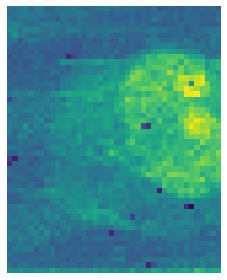

In [3]:
def plot_image(img, cmap = 'viridis'):
    if img.ndim == 3:
        img = img.mean(axis = 2)
    fig, ax = plt.subplots(1, 1, figsize = (5,4))
    ax.imshow(img, cmap = cmap, interpolation = 'nearest')
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    
def plot_images(img_list, labels = None, cmap = 'viridis'):
    n = len(img_list)
    fig, ax = plt.subplots(1, n, figsize = (5 * n, 4), constrained_layout = True)
    for i in range(n):
        img = img_list[i]
        if img.ndim == 3:
            img = img.mean(axis = 2)
        ax[i].imshow(img, cmap = cmap, interpolation = 'nearest')
        ax[i].axis('off')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        if labels is not None:
            ax[i].set_title(labels[i])
    #fig.tight_layout()
    #fig.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    
plot_image(img)

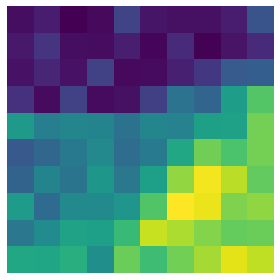

In [4]:
def get_image_patch(image, patch_size):                   
    if image.shape[0] > patch_size:
        start_idx_x = int(np.round(np.random.random() * (image.shape[0] - patch_size)))
        end_idx_x = start_idx_x + patch_size
    else:
        start_idx_x = 0
        end_idx_x = image.shape[0]

    if image.shape[1] > patch_size:
        start_idx_y = int(np.round(np.random.random() * (image.shape[1] - patch_size)))
        end_idx_y = start_idx_y + patch_size
    else:
        start_idx_y = 0
        end_idx_y = image.shape[1]

    image_patch = image[start_idx_x:end_idx_x, start_idx_y:end_idx_y, :]
    return image_patch

patch = get_image_patch(img, 10)
plot_image(patch)

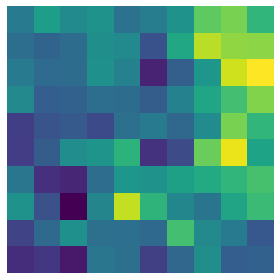

In [5]:
def center_crop_image(image, image_size):
    cropped_image = image.copy()
    if image.shape[0] > image_size:
        dif = int(np.floor((image.shape[0] - image_size) / 2))
        cropped_image = cropped_image[dif:image_size+dif,:,:]

    if image.shape[1] > image_size:
        dif = int(np.floor((image.shape[1] - image_size) / 2))
        cropped_image = cropped_image[:,dif:image_size+dif,:]
        
    return cropped_image

center = center_crop_image(img, 10)
plot_image(center)

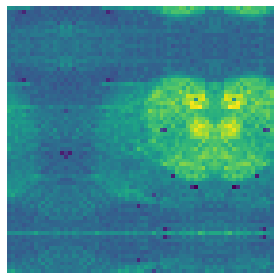

In [6]:
def pad_image(image, size, patch):
    if image.shape[0] == size and image.shape[1] == size:
        padded_image = image.copy()
    elif image.shape[0] > size and image.shape[1] > size:
        if patch:
            padded_image = get_image_patch(image, size)
        else:
            padded_image = center_crop_image(image, size)                    
    else:
        # pad with reflection around edges if requested size is bigger than image dimensions
        padded_image = image.copy()
        if padded_image.shape[0] > size:
            if patch:
                padded_image = get_image_patch(padded_image, size)
            else:
                padded_image = center_crop_image(padded_image, size) 
        else:           
            pad_before = int(np.floor((size - padded_image.shape[0]) / 2))
            pad_after = int(np.ceil((size - padded_image.shape[0]) / 2))
            padded_image = np.pad(padded_image, ((pad_before, pad_after), (0,0), (0,0)), 'reflect')

        if padded_image.shape[1] > size:
            if patch:
                padded_image = get_image_patch(padded_image, size)
            else:
                padded_image = center_crop_image(padded_image, size) 
        else:           
            pad_before = int(np.floor((size - padded_image.shape[1]) / 2))
            pad_after = int(np.ceil((size - padded_image.shape[1]) / 2))
            padded_image = np.pad(padded_image, ((0,0), (pad_before, pad_after), (0,0)), 'reflect')

    return padded_image

padded = pad_image(img, size = 70, patch = False)
plot_image(padded)

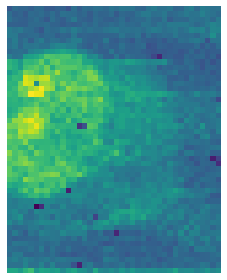

In [7]:
def flip_axis(image, axis):
    image = np.asarray(image).swapaxes(axis, 0)
    image = image[::-1, ...]
    image = image.swapaxes(0, axis)
    return image

flipped = flip_axis(img, 1)
plot_image(flipped)

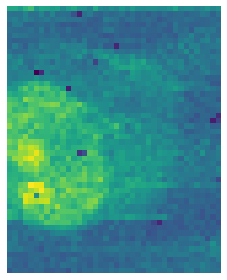

In [8]:
def rotate_spectral_image(image, rotation_extent):
    #rotation_extent = np.random.random()
    if rotation_extent < 0.25:
        rotation = 1
    elif rotation_extent < 0.5:
        rotation = 2
    elif rotation_extent < 0.75:
        rotation = 3
    else:
        rotation = 0
    image = np.rot90(image, rotation)
    return image

rotated = rotate_spectral_image(img, 0.4)
plot_image(rotated)

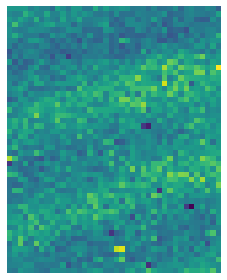

In [9]:
def shift_spectrum(image, shift_range):
    # shift spectra left or right and pad with reflection to recover original length
    shifted_spectrum_image = image.copy()
    spectrum_shift_range = int(np.round(shift_range * image.shape[2]))
    if spectrum_shift_range > 0:
        shifted_spectrum_image = np.pad(image[:,:,spectrum_shift_range:], 
                                        ((0,0), (0,0), (0, abs(spectrum_shift_range))), 
                                        'reflect')
    elif spectrum_shift_range < 0:
        shifted_spectrum_image = np.pad(image[:,:,:spectrum_shift_range], 
                                        ((0,0), (0,0), (abs(spectrum_shift_range), 0)), 
                                        'reflect')
    return shifted_spectrum_image

shifted = shift_spectrum(img, -0.8)
plot_image(shifted)

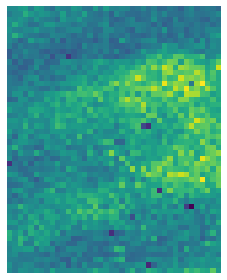

In [10]:
def spectrum_padding(image, spectrum_length):
    # truncate spectral dimension or expand and pad with reflection
    if image.shape[-1] == spectrum_length:
        padded_spectrum_image = image.copy()
    elif image.shape[-1] > spectrum_length:
        padded_spectrum_image = image[:,:,0:spectrum_length]
    else:
        padded_spectrum_image = np.pad(image, ((0,0), (0,0), (0, spectrum_length - image.shape[-1])), 'reflect')
    return padded_spectrum_image

spec_padded = spectrum_padding(img, 200)
plot_image(spec_padded)

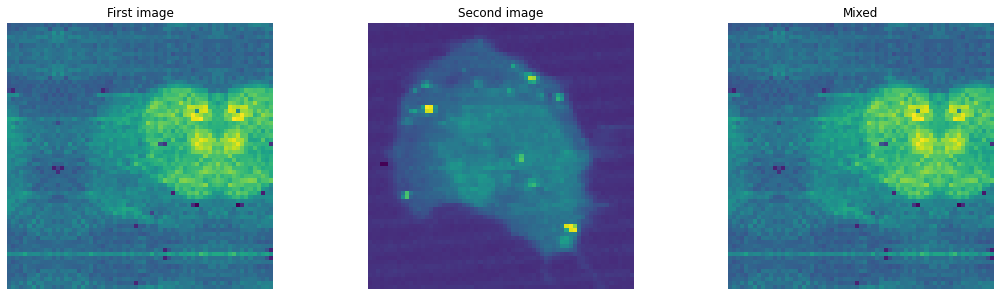

In [11]:
def image_mixup(image1, image2, alpha):
    lam = np.random.beta(alpha, alpha)
    image = (lam * image1) + ((1 - lam) * image2)
    return image

img2 = load_image(path, 'Cell-HR_Norm_500-03-117-169')
img_padded = pad_image(img, size = 65, patch = True)
mixed = image_mixup(img_padded, img2, 0.75)
plot_images([img_padded, img2, mixed], labels = ['First image', 'Second image', 'Mixed'])

Downsampled shape: (25, 20, 500)


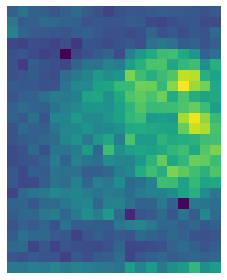

In [12]:
def normalise_image(image):
    # scales all values by max value
    image_max = np.tile(np.amax(image), image.shape)  # just image max repeated at every location
    normalised_image = np.divide(image, image_max)  
    return normalised_image

def downsample_image(image, scale = 4):
    if scale >= 4:
        start_idx = np.random.randint(1, scale - 1)
    else:
        start_idx = 1 
    downsampled_image = image[start_idx::scale, start_idx::scale, :]
    return downsampled_image

downsampled = downsample_image(img, scale = 2)
print('Downsampled shape:', downsampled.shape)
plot_image(downsampled)

In [61]:
# write out image IDs to file
def write_id_file(path):
    files = os.listdir(path)
    files = sorted([f[:-4] for f in files if f.split('.')[-1] == 'mat'])
    df = pd.DataFrame({'id': files})
    df.to_csv(os.path.join(path, 'Image_IDs.csv'), index = False)
    
write_id_file(path)

Original shape: (50, 40, 500)
Downsampled shape: (25, 20, 500)
Nearest neighbor upsampling shape: (50, 40, 500)
Bicubic upsampling shape: (50, 40, 500)


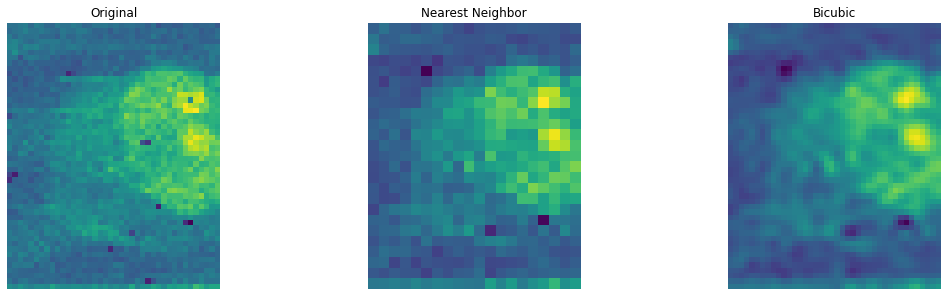

In [13]:
# nearest neighbor upsampling and bicubic upsampling
scale = 2
neighbor = scipy.ndimage.zoom(downsampled, (scale, scale, 1), order = 0)
bicubic = scipy.ndimage.zoom(downsampled, (scale, scale, 1), order = 3)

print('Original shape:', img.shape)
print('Downsampled shape:', downsampled.shape)
print('Nearest neighbor upsampling shape:', neighbor.shape)
print('Bicubic upsampling shape:', bicubic.shape)

plot_images([img, neighbor, bicubic], 
            labels = ['Original', 'Nearest Neighbor', 'Bicubic'])

In [42]:
def calc_MSE(source, target):
    return np.mean((source - target)**2)

def calc_PSNR(source, target):
    psnr = 0.
    mse = np.mean((source - target)**2)
    psnr = 10 * np.log10(np.max(source) / mse)
    return psnr

def calc_SSIM(source, target):
    data_range = source.max() - target.max()
    ssim = sk_ssim(source, target, data_range = data_range, channel_axis = 2)
    return ssim

print('MSE:', calc_MSE(bicubic, img))
print('PSNR:', calc_PSNR(bicubic, img))
print('SSIM:', calc_SSIM(bicubic, img))

MSE: 9.781194671598054e-05
PSNR: 39.62741319201923
SSIM: 0.3805159784755131


In [43]:
def calc_psnr(output, target):
    output = torch.tensor(output)
    target = torch.tensor(target)
    psnr = 0.
    mse = nn.MSELoss()(output, target)
    psnr = 10 * math.log10(torch.max(output) / mse)
    return psnr

def calc_ssim(output, target):
    output = torch.tensor(output)
    target = torch.tensor(target)
    ssim = 0.
    output = output.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    
    if output.ndim == 4:
        for i in range(output.shape[0]):
            output_i = np.squeeze(output[i,:,:,:])
            #output_i = np.moveaxis(output_i, 0, -1)
            target_i = np.squeeze(target[i,:,:,:])
            #target_i = np.moveaxis(target_i, 0, -1)
            batch_size = output.shape[0]
            ssim += sk_ssim(output_i, target_i, data_range = output_i.max() - target_i.max(), channel_axis = 2)
    else:
        output_i = np.squeeze(output)
        #output_i = np.moveaxis(output_i, 0, -1)
        target_i = np.squeeze(target)
        #target_i = np.moveaxis(target_i, 0, -1)
        batch_size = 1
        ssim += sk_ssim(output_i, target_i, data_range = output_i.max() - target_i.max(), channel_axis = 2)
        
    ssim = ssim / batch_size
    return ssim

#calc_psnr(bicubic, img)
calc_ssim(bicubic, img)

0.3805159784755131